### **Introduction**
The data consists of 1601 cone-beam projections with a detector of size 1006x1006. The scanned specimen was [foraminifera](https://en.wikipedia.org/wiki/Foraminifera), a microscopic marine organism.

In [1]:
INPUT_PATH = '/dtu/3d-imaging-center/courses/CIL-QIM25_workshop/data/foraminifera/Amphi_13363_10X-40kV-LE1-20s-1p45micro.txrm'
CENTRE_OF_ROTATION_OFFSET = 0.046424131475367544

As a baseline, we will use the fast FDK algorithm for cone-beam filtered backprojection. This is usually sufficient when projections are plentiful. When that is not the case, however, the reconstruction can be sensitive to noise and exhibit streak artifacts.

Optimisation-based iterative algorithms offer an alternative by balancing fidelity with regularization. In this notebook, we compare two such approaches:
- FISTA with a nonnegativity constraint
- FISTA with total variation (TV) regularization (and nonnegativity)

### **Module imports**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import qim3d

# CIL imports
import cil
from cil.io import ZEISSDataReader
from cil.framework import ImageGeometry, AcquisitionGeometry, BlockDataContainer
from cil.processors import TransmissionAbsorptionConverter
from cil.recon import FDK
from cil.optimisation.algorithms import GD, FISTA, SIRT, CGLS
from cil.optimisation.functions import LeastSquares, IndicatorBox, TotalVariation
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator
from cil.plugins.tigre import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.utilities.display import show_geometry, show2D
from cil.optimisation.utilities import callbacks

### **User parameters**

Here we introduce the configurable parameters that control the data used for the reconstruction experiments. The primary aim is to study how projection subsampling affects different algorithms and the resulting image analysis. Additional options for detector subsampling and vertical cropping allow faster processing during testing by reducing data size.

The parameters are:
- `PROJECTION_SUBSAMPLING`: controls the spacing between the projections. A value of $1$ corresponds to using all projections and a value of $5$ would reduce the projections by a factor $5$.
- `DETECTOR_SUBSAMPLING`: controls the spacing between pixels in both horizontal and vertical directions on of the detector array. A value of $1$ uses all pixels, and a value of $2$ reduces the total number of pixels by a factor of $2^2$.
- `VERTICAL_CROP_RATIO`: fraction of slices to keep as a centered vertical crop of the volume. A value of $1$ corresponds to no cropping, and a value of $0.5$ would discard $25\%$ from top and bottom. To speed up computations during testing, a value such as $0.05$ can be used, though very small values (that would result in a single slice) will cause errors in the CIL reader.

In [3]:
PROJECTION_SUBSAMPLING = 10
DETECTOR_SUBSAMPLING = 1
VERTICAL_CROP_RATIO = 0.05

### **Data reading and preprocessing**

In [4]:
DataReader = ZEISSDataReader

def get_pixel_nums():
    reader = DataReader(file_name=INPUT_PATH)
    num_pixels_horizontal = reader.get_geometry().pixel_num_h
    num_pixels_vertical = reader.get_geometry().pixel_num_v
    return num_pixels_horizontal, num_pixels_vertical

num_pixels_horizontal, num_pixels_vertical = get_pixel_nums()

slice_dict = {
    'angle': (None, None, PROJECTION_SUBSAMPLING),
    'vertical': (
        int((1 - VERTICAL_CROP_RATIO) * num_pixels_vertical // 2),
        int((1 + VERTICAL_CROP_RATIO) * num_pixels_vertical // 2),
        DETECTOR_SUBSAMPLING,
    ),
    'horizontal': (None, None, DETECTOR_SUBSAMPLING),
}
reader = DataReader(file_name=INPUT_PATH, roi=slice_dict)

In [5]:
slice_dict

{'angle': (None, None, 10),
 'vertical': (477, 528, 1),
 'horizontal': (None, None, 1)}

In [6]:
data = reader.read() # may result in error if there is only one slice in the vertical direction

In [7]:
print(data)

Number of dimensions: 3
Shape: (161, 51, 1006)
Axis labels: ('angle', 'vertical', 'horizontal')



In [8]:
ag = data.geometry
horizontal_index = data.get_data_axes_order().index('horizontal')
scaled_offset = CENTRE_OF_ROTATION_OFFSET * (data.shape[horizontal_index] / num_pixels_horizontal)
ag.set_centre_of_rotation(offset=scaled_offset)

ig = ag.get_ImageGeometry()

We configured the acquisition geometry with a centre of rotation offset that was precalculated by optimizing with the `image_sharpness` method from the CIL `CentreOfRotationCorrector`. Because this step is compute-intensive, the result was stored and hardcoded.

In [9]:
# qim3d.viz.slicer(data.array, color_map='grey', color_bar='slices', image_height=6, image_width=6)

In [10]:
data = TransmissionAbsorptionConverter()(data)

### **FDK reconstruction**

In [11]:
data.reorder(order='tigre')
recon = FDK(data).run(verbose=0)

In [12]:
qim3d.viz.slicer(recon.array, color_map='grey', color_bar='slices', image_height=6, image_width=6)

interactive(children=(IntSlider(value=25, description='Slice', max=50), Output()), layout=Layout(align_items='…

### **Optimization-based iterative algorithms**

In [13]:
A = ProjectionOperator(image_geometry=ig, acquisition_geometry=ag)
x0 = ig.allocate(0.0)

### **FISTA with nonnegativity constraint**

In [14]:
F = LeastSquares(A, data)
G = IndicatorBox(lower=0.0, accelerated=False) # nonnegativity

`update_objective_interval` can be set to a higher value for faster iterations but less frequent updates about the objective values.

In [15]:
fista_nn = FISTA(f=F, g=G, initial=x0, update_objective_interval=1)

You can change the `iterations` parameter and rerun the cell below to continue performing iterations if the algorithm has not yet converged.

     0/20         ?it/s
     1/20      4.51s/it, objective=+3.591e+05
     2/20      4.50s/it, objective=+2.397e+05
     3/20      4.50s/it, objective=+1.581e+05
     4/20      4.50s/it, objective=+1.072e+05
     5/20      4.50s/it, objective=+7.746e+04
     6/20      4.50s/it, objective=+6.021e+04
     7/20      4.50s/it, objective=+4.957e+04
     8/20      4.50s/it, objective=+4.233e+04
     9/20      4.50s/it, objective=+3.703e+04
    10/20      4.50s/it, objective=+3.309e+04
    11/20      4.50s/it, objective=+3.017e+04
    12/20      4.50s/it, objective=+2.798e+04
    13/20      4.51s/it, objective=+2.628e+04
    14/20      4.50s/it, objective=+2.493e+04
    15/20      4.50s/it, objective=+2.384e+04
    16/20      4.50s/it, objective=+2.295e+04
    17/20      4.50s/it, objective=+2.222e+04
    18/20      4.50s/it, objective=+2.163e+04
    19/20      4.50s/it, objective=+2.112e+04
    20/20      4.50s/it, objective=+2.070e+04
    20/20      4.50s/it



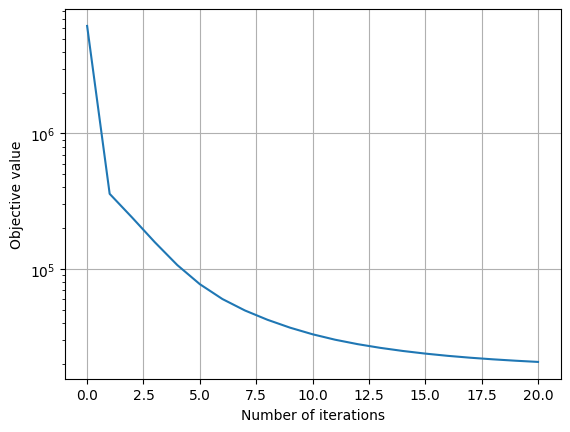

In [16]:
fista_nn.run(iterations=20, verbose=1, callbacks=[callbacks.TextProgressCallback()])

plt.plot(fista_nn.objective)
plt.gca().set_yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')
plt.grid()

In [17]:
qim3d.viz.slicer(fista_nn.solution.array, color_map='grey', color_bar='slices', image_height=6, image_width=6)

interactive(children=(IntSlider(value=25, description='Slice', max=50), Output()), layout=Layout(align_items='…

### **FISTA with TV regularization**

The parameter `alpha` can be modified to control the regularization strength.

In [18]:
alpha = 0.01
F = LeastSquares(A, data)
G = FGP_TV(alpha, device='gpu', nonnegativity=True)

In [19]:
fista_tv = FISTA(f=F, g=G, initial=x0, update_objective_interval=1)

     0/20         ?it/s
     1/20      6.35s/it, objective=+3.593e+05
     2/20      6.34s/it, objective=+2.412e+05
     3/20      6.34s/it, objective=+1.607e+05
     4/20      6.34s/it, objective=+1.105e+05
     5/20      6.34s/it, objective=+8.135e+04
     6/20      6.34s/it, objective=+6.462e+04
     7/20      6.34s/it, objective=+5.454e+04
     8/20      6.34s/it, objective=+4.787e+04
     9/20      6.34s/it, objective=+4.313e+04
    10/20      6.34s/it, objective=+3.973e+04
    11/20      6.34s/it, objective=+3.733e+04
    12/20      6.34s/it, objective=+3.558e+04
    13/20      6.34s/it, objective=+3.428e+04
    14/20      6.34s/it, objective=+3.331e+04
    15/20      6.34s/it, objective=+3.258e+04
    16/20      6.34s/it, objective=+3.203e+04
    17/20      6.34s/it, objective=+3.162e+04
    18/20      6.34s/it, objective=+3.131e+04
    19/20      6.34s/it, objective=+3.107e+04
    20/20      6.34s/it, objective=+3.088e+04
    20/20      6.34s/it



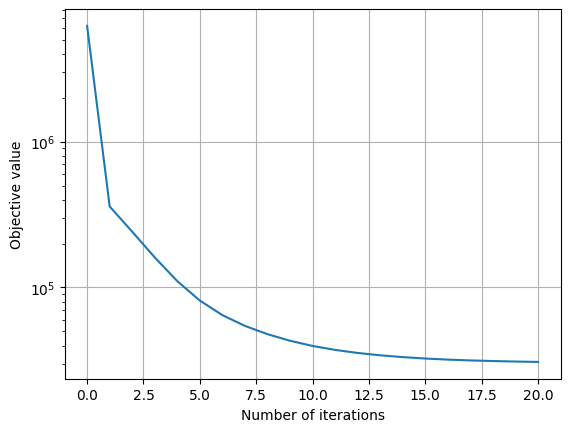

In [20]:
fista_tv.run(iterations=20, verbose=1, callbacks=[callbacks.TextProgressCallback()])

plt.plot(fista_tv.objective)
plt.gca().set_yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Objective value')
plt.grid()

In [21]:
qim3d.viz.slicer(fista_tv.solution.array, color_map='grey', color_bar='slices', image_height=6, image_width=6)

interactive(children=(IntSlider(value=25, description='Slice', max=50), Output()), layout=Layout(align_items='…

### **Export the reconstruction**

Choose which volume to be exported and used for the subsequent image analysis.

In [ ]:
recon_to_save = ... #  set this, e.g. fista_nn.solution.array
filename = './recon.tif'
qim3d.io.save(filename, recon_to_save, replace=True)